# Preprocessing pipeline [dev]

The goal of this pipeline is to produce preprocessed data that is clean enough to be further analyzed in ERP or connectivity analyzes. This pipeline is semi-automatic; manual steps are not necessarily required, but it is advised to revisit the cleaned epochs. ICA components have to be selected manually.

## Steps
Considering the remarks [here](https://autoreject.github.io/faq.html#should-i-apply-ica-first-or-autoreject-first)


- bandpass filter 0.1-45Hz
- create fixed length epochs
- mark and reject bad data segments with [autoreject](https://www.sciencedirect.com/science/article/abs/pii/S1053811917305013)
- fit ICA on cleaned data segments
- process components
- apply ICA
- run autoreject with more strict thresholds


## Install package requirements

Can be ignored if requirements are already installed.

In [ ]:
!pip install -r ../requirements.txt

## Import packages


```%matplotlib qt``` is for interactive visualization (can be slower); 
switch to ```%matplotlib inline``` for (faster) static plots

In [3]:
import os
from pathlib import Path
from ipyfilechooser import FileChooser

from eeg_preprocessing.run_preprocessing import *
from eeg_preprocessing.utils.events import get_events_from_raw


from matplotlib import pyplot as plt
%matplotlib qt

## Load raw data

In [4]:
# Set base path to EEG data
base_path = 'D:\weiglszonja/Raw_data'

# Create folder for preprocessed and interim files
folder_name = 'preprocessed'
interim_path = os.path.join(base_path, folder_name)

if not os.path.exists(interim_path):
    os.makedirs(interim_path)

In [5]:
# Choose a file using a FileChooser widget
fc = FileChooser(base_path)
fc.filter_pattern = '*.vhdr'

display(fc)

FileChooser(path='D:\weiglszonja/Raw_data', filename='', title='HTML(value='', layout=Layout(display='none'))'…

In [6]:
# Load selected file
raw_file_path = fc.selected
raw_id = Path(raw_file_path).stem
id_split = raw_id.split('_')
subject = id_split[0]
condition = id_split[1]
num_day = [x for x in id_split[-1] if x.isdigit()][0]

raw = mne.io.read_raw_brainvision(raw_file_path, preload=False, verbose=True)

Extracting parameters from D:\weiglszonja\Raw_data\15_L\Day2\EEG\15_L_Day2.vhdr...
Setting channel info structure...


## Event processing

In [8]:
resting_events, block_events = get_events_from_raw(raw)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  5', 'Stimulus/S 83', 'Stimulus/S 84', 'Stimulus/S 85', 'Stimulus/S 87', 'Stimulus/S 88', 'Stimulus/S 89', 'Stimulus/S 91', 'Stimulus/S 92', 'Stimulus/S 93', 'Stimulus/S 94', 'Stimulus/S 95', 'Stimulus/S 96', 'Stimulus/S 97', 'Stimulus/S 98', 'Stimulus/S 99', 'Stimulus/S100', 'Stimulus/S106', 'Stimulus/S110', 'Stimulus/S112', 'Stimulus/S113', 'Stimulus/S114', 'Stimulus/S115', 'Stimulus/S116', 'Stimulus/S117', 'Stimulus/S118', 'Stimulus/S119', 'Stimulus/S120', 'Stimulus/S122', 'Stimulus/S123', 'Stimulus/S124', 'Stimulus/S125', 'Stimulus/S126', 'Stimulus/S127', 'Stimulus/S128', 'Stimulus/S129', 'Stimulus/S132', 'Stimulus/S133', 'Stimulus/S134', 'Stimulus/S135', 'Stimulus/S136', 'Stimulus/S137', 'Stimulus/S138', 'Stimulus/S139', 'Stimulus/S140', 'Stimulus/S141', 'Stimulus/S142', 'Stimulus/S143', 'Stimulus/S144', 'Stimulus/S145', 'Stimulus/S146', 'Stimulus/S147', 'Stimulus/S148', 'Stimulus/S149', 'Stimulus/S151', 'Stimulus/S152', 

D:\weiglszonja\eeg-preprocessing\eeg_preprocessing\utils\events.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  block_events['real_start_time'] = block_start_times
D:\weiglszonja\eeg-preprocessing\eeg_preprocessing\utils\events.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  block_events['end_time'] = events_df[events_df['event_id'] == 152]['start_time'].values
D:\weiglszonja\eeg-preprocessing\eeg_preprocessing\utils\events.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

## Cut raw data based on triggers


## I. Resting period

### Create folder for preprocessed files

In [ ]:
# Create path to interim epoch files
interim_epochs_path = os.path.join(interim_path, condition, 'epochs_rs')
if not os.path.exists(interim_epochs_path):
    os.makedirs(interim_epochs_path)

### Crop raw data

In [ ]:
period = f'rs_{num_day}_1'
raw_rs_1 = concat_raws_from_events(resting_events[resting_events['event'] == period], raw)
raw_rs_1.info['fid'] = f'{subject}_{condition}_{period}'
print(raw_rs_1.info['fid'])

period = f'rs_{num_day}_2'
raw_rs_2 = concat_raws_from_events(resting_events[resting_events['event'] == period], raw)
raw_rs_2.info['fid'] = f'{subject}_{condition}_{period}'
print(raw_rs_2.info['fid'])

### Visualize raw resting segment (optional)

In [ ]:
# interactively scroll through data
raw_rs_1.plot(title=raw_rs_1.info['fid'],
              n_channels=32,
              remove_dc=True)

In [ ]:
# interactively scroll through data
raw_rs_2.plot(title=raw_rs_2.info['fid'],
              n_channels=32,
              remove_dc=True)

## Run preprocessing

### 1. Run ICA

In [ ]:
ica, epochs_rs_1  = run_ica(raw=raw_rs_1)
ica.plot_sources(epochs_rs_1, start=0, stop=10)

In [ ]:
ica.apply(epochs_rs_1)
epochs_rs_1.info['description'] = f'n_components: {len(ica.exclude)}'

In [ ]:
fid = raw_rs_1.info['fid']
epochs_clean_fname = f'{fid}_ICA'
postfix = '-epo.fif.gz'
epochs_rs_1.save(os.path.join(interim_epochs_path, f'{epochs_clean_fname}{postfix}'), overwrite=True)

In [ ]:
raw_rs_1.info['fid']

In [ ]:
ica, epochs_rs_2 = run_ica(raw=raw_rs_2)
ica.plot_sources(epochs_rs_2, start=0, stop=10)

In [ ]:
ica.apply(epochs_rs_2)
epochs_rs_2.info['description'] = f'n_components: {len(ica.exclude)}'

In [ ]:
fid = raw_rs_2.info['fid']
epochs_clean_fname = f'{fid}_ICA'
postfix = '-epo.fif.gz'
epochs_rs_2.save(os.path.join(interim_epochs_path, f'{epochs_clean_fname}{postfix}'), overwrite=True)

### 2. Run autoreject

In [ ]:
epochs_autoreject_rs_1 = run_autoreject(epochs_rs_1)

In [ ]:
epochs_autoreject_rs_1.plot_drop_log()

In [ ]:
epochs_rs_1.plot(n_epochs=10)

In [ ]:
# save clean epochs
fid = raw_rs_1.info['fid']
epochs_clean_fname = f'{fid}_ICA_autoreject'
postfix = '-epo.fif.gz'
epochs_autoreject_rs_1.save(os.path.join(interim_epochs_path, f'{epochs_clean_fname}{postfix}'), overwrite=True)

In [ ]:
del epochs_rs_1

In [ ]:
epochs_autoreject_rs_2 = run_autoreject(epochs_rs_2)

In [ ]:
epochs_autoreject_rs_2.plot_drop_log()

In [ ]:
epochs_autoreject_rs_2.plot(n_epochs=10)

In [ ]:
# save clean epochs
fid = raw_rs_2.info['fid']
epochs_clean_fname = f'{fid}_ICA_autoreject'
postfix = '-epo.fif.gz'
epochs_autoreject_rs_2.save(os.path.join(interim_epochs_path, f'{epochs_clean_fname}{postfix}'), overwrite=True)

In [ ]:
del epochs_rs_2

### 3. Run ransac

In [ ]:
epochs_ransac_rs_1 = run_ransac(epochs_autoreject_rs_1)
# set average reference
epochs_ransac_rs_1.set_eeg_reference()

In [ ]:
epochs_ransac_rs_1.info

In [ ]:
epochs_autoreject_rs_1.info['bad_channels_autoreject']

In [ ]:
epochs_ransac_rs_1.plot(n_epochs=10)

In [ ]:
if epochs_autoreject_rs_1.info['bad_channels_autoreject']:
    epochs_ransac_rs_1.info.update(bads=epochs_autoreject_rs_1.info['bad_channels_autoreject'])
    bads_str = ', '.join(epochs_autoreject_rs_1.info['bad_channels_autoreject'])
    epochs_ransac_rs_1.info.update(description=epochs_ransac_rs_1.info['description'] + ', interpolated: ' + bads_str)
    epochs_ransac_rs_1.interpolate_bads()

epochs_ransac_rs_1.set_eeg_reference()

In [ ]:
# save clean epochs
fid = raw_rs_1.info['fid']
epochs_clean_fname = f'{fid}_ICA_autoreject_ransac'
postfix = '-epo.fif.gz'
epochs_ransac_rs_1.save(os.path.join(interim_epochs_path, f'{epochs_clean_fname}{postfix}'), overwrite=True)

In [ ]:
epochs_autoreject_rs_2.info['bad_channels_autoreject']

In [ ]:
epochs_ransac_rs_2 = run_ransac(epochs_autoreject_rs_2)
# set average reference
#epochs_ransac_rs_2.set_eeg_reference()

In [ ]:
if epochs_autoreject_rs_2.info['bad_channels_autoreject']:
    epochs_ransac_rs_2.info.update(bads=epochs_autoreject_rs_2.info['bad_channels_autoreject'])
    bads_str = ', '.join(epochs_autoreject_rs_2.info['bad_channels_autoreject'])
    epochs_ransac_rs_2.info.update(description=epochs_ransac_rs_2.info['description'] + ', interpolated: ' + bads_str)
    epochs_ransac_rs_2.interpolate_bads()

epochs_ransac_rs_2.set_eeg_reference()

In [ ]:
epochs_ransac_rs_2.info

In [ ]:
epochs_ransac_rs_2.plot(n_epochs=10)

In [ ]:
epochs_ransac_rs_2.interpolate_bads()

epochs_ransac_rs_2.set_eeg_reference()

In [ ]:
# save clean epochs
fid = raw_rs_2.info['fid']
epochs_clean_fname = f'{fid}_ICA_autoreject_ransac'
postfix = '-epo.fif.gz'
epochs_ransac_rs_2.save(os.path.join(interim_epochs_path, f'{epochs_clean_fname}{postfix}'), overwrite=True)

In [ ]:
del epochs_autoreject_rs_1, epochs_autoreject_rs_2

In [ ]:
test = mne.read_epochs('D:/weiglszonja/Raw_data/preprocessed/L/epochs_rs/8_L_rs_2_ICA_autoreject_ransac-epo.fif.gz')

In [ ]:
test.info
# when dropping epochs could use epochs_ar.copy().drop

## II. ASRT

### Create folder for preprocessed files

In [9]:
# Create path to interim epoch files
interim_epochs_path = os.path.join(interim_path, condition, 'epochs_asrt')
if not os.path.exists(interim_epochs_path):
    os.makedirs(interim_epochs_path)

# Create path to interim raw files
interim_raw_path = os.path.join(interim_path, condition, 'raw_asrt')
if not os.path.exists(interim_raw_path):
    os.makedirs(interim_raw_path)

### Crop raw data
#### 1. Sequence A

In [10]:
raw_asrt_seqA = concat_raws_from_events(block_events[block_events['sequence'] == 'A'], raw)

#### 2. Sequence B

In [ ]:
raw_asrt_seqB = concat_raws_from_events(block_events[block_events['sequence'] == 'B'], raw)

### Run ICA

Running ICA takes approximately 5 mins. Grab a coffee.

Reading 0 ... 1431624  =      0.000 ...  2863.248 secs...
Filtering raw data in 25 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 sec)

Not setting metadata
Not setting metadata
2863 matching events found
No baseline correction applied
0 projection items activated
Loading data for 2863 events and 500 original time points ...
24 bad epochs dropped
Preliminary epoch rejection: 
Bad by amplitude:
	[ 220  369  550  667  784  785  823 1177 1431 1564 1578 1604 1605 1609
 1639 1994 2041 2042 2062 2068 2069 2310 

c:\programdata\anaconda3\envs\eeg-preprocessing\lib\site-packages\mne\preprocessing\infomax_.py:192: RuntimeWarning: overflow encountered in exp
  y = 1.0 / (1.0 + np.exp(-u))


Fitting ICA took 288.7s.
Not setting metadata
Not setting metadata
2712 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


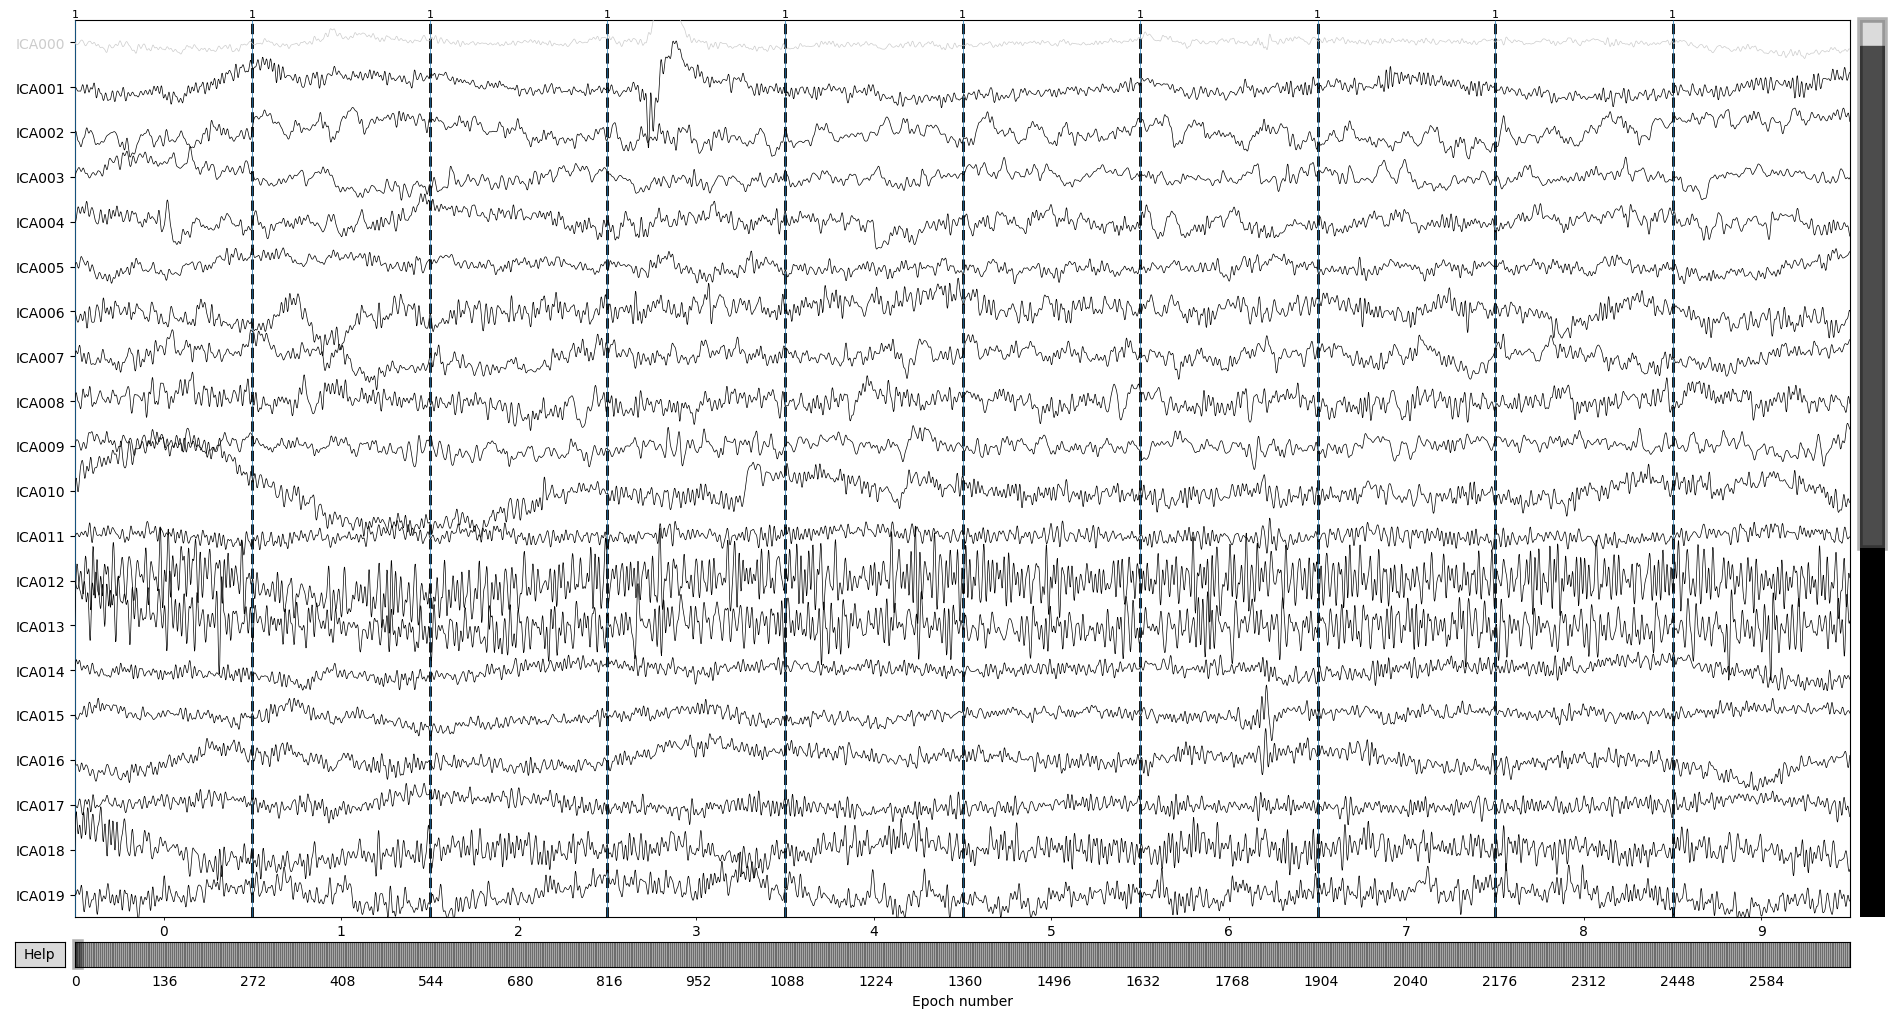

In [11]:
ica, epochs_ica = run_ica(raw=raw_asrt_seqB)
ica.plot_sources(epochs_ica, start=0, stop=10)

In [ ]:
raw_asrt_seqA.plot()

In [ ]:
ica, epochs_ica = run_ica(raw=raw_asrt_seqA)
ica.plot_sources(epochs_ica, start=0, stop=10)

In [12]:
ica.apply(epochs_ica)
epochs_ica.info['description'] = f'n_components: {len(ica.exclude)}'

Applying ICA to Epochs instance
    Transforming to ICA space (32 components)
    Zeroing out 1 ICA component
    Projecting back using 64 PCA components


In [13]:
f'{subject}_{condition}_asrt_{num_day}'

'15_L_asrt_2'

In [14]:
fid = f'{subject}_{condition}_asrt_{num_day}'
epochs_clean_fname = f'{fid}_ICA'
postfix = '-epo.fif.gz'
epochs_ica.save(os.path.join(interim_epochs_path, f'{epochs_clean_fname}{postfix}'), overwrite=True)

#### Add annotations to raw data

In [15]:
events = mne.make_fixed_length_events(raw_asrt_seqB,
                                  id=1,
                                  first_samp=True,
                                  duration=1.0,
                                  overlap=0.0)

start_times = [events[idx][0] / raw.info['sfreq'] for idx, value in enumerate(epochs_ica.drop_log) if 'FASTER' in value]
raw_asrt_seqB.annotations.append(onset=start_times,
                                  duration=[1.0] * len(start_times),
                                 description='BAD_auto')

<Annotations | 5900 segments: BAD boundary (24), BAD_auto (127), EDGE ...>

In [ ]:
events = mne.make_fixed_length_events(raw_asrt_seqA,
                                  id=1,
                                  first_samp=True,
                                  duration=1.0,
                                  overlap=0.0)

start_times = [events[idx][0] / raw.info['sfreq'] for idx, value in enumerate(epochs_ica.drop_log) if 'FASTER' in value]
raw_asrt_seqA.annotations.append(onset=start_times,
                                  duration=[1.0] * len(start_times),
                                 description='BAD_auto')

In [ ]:
del epochs_ransac_rs_1, epochs_ransac_rs_2

### Run autoreject

In [ ]:
epochs_autoreject = run_autoreject(epochs_ica, n_jobs=11, subset=True)

Fitting autoreject on random subset of epochs: 
Running autoreject on ch_type=eeg


In [ ]:
epochs_autoreject.plot_drop_log()

In [ ]:
epochs_autoreject.plot()

In [ ]:
# save clean epochs
epochs_clean_fname = f'{fid}_ICA_autoreject'
postfix = '-epo.fif.gz'
epochs_autoreject.save(os.path.join(interim_epochs_path, f'{epochs_clean_fname}{postfix}'), overwrite=True)

In [ ]:
start_times = [events[idx][0] / raw.info['sfreq'] for idx, value in enumerate(epochs_autoreject.drop_log) if 'AUTOREJECT' in value]
raw_asrt_seqB.annotations.append(onset=start_times,
                                  duration=[1.0] * len(start_times),
                                 description='BAD_auto')

In [ ]:
start_times = [events[idx][0] / raw.info['sfreq'] for idx, value in enumerate(epochs_autoreject.drop_log) if 'AUTOREJECT' in value]
raw_asrt_seqA.annotations.append(onset=start_times,
                                  duration=[1.0] * len(start_times),
                                 description='BAD_auto')

In [ ]:
epochs_ransac = run_ransac(epochs_autoreject)

In [ ]:
epochs_ransac.info

In [ ]:
epochs_autoreject.info['bad_channels_autoreject']

In [ ]:
if epochs_autoreject.info['bad_channels_autoreject']:
    epochs_ransac.info.update(bads=epochs_autoreject.info['bad_channels_autoreject'])
    bads_str = ', '.join(epochs_ransac.info['bad_channels_autoreject'])
    epochs_ransac.info.update(description=epochs_ransac.info['description'] + ', interpolated: ' + bads_str)
    epochs_ransac.interpolate_bads()

epochs_ransac.set_eeg_reference()

In [ ]:
# save clean epochs
epochs_clean_fname = f'{fid}_ICA_autoreject_ransac'
postfix = '-epo.fif.gz'
epochs_ransac.save(os.path.join(interim_epochs_path, f'{epochs_clean_fname}{postfix}'), overwrite=True)

In [ ]:
fname = f'{fid}_seqB_annotated'
postfix = '-raw.fif.gz'
raw_asrt_seqB.save(os.path.join(interim_raw_path, f'{fname}{postfix}'), overwrite=True)

In [ ]:
fname = f'{fid}_seqA_annotated'
postfix = '-raw.fif.gz'
raw_asrt_seqA.save(os.path.join(interim_raw_path, f'{fname}{postfix}'), overwrite=True)

In [ ]:
epochs_ransac.plot(n_epochs=10)

In [ ]:
plt.close('all')